## Bonus for VG
I got the dataset for glasses to work ok in the end, so I'll leave it as a bonus or VG-essay

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Preprocessing

In [ ]:
# Before loading pictures they have been preprocessed and resaved locally with these three rows of code
# Saved as 48x48 pictures in grayscale since downloaded dataset was bigger pictures in color
# I ran the code once for pictures with glasses and once for pictures with no glasses
# I had to do this change in pictures since the Haarscascade in real-time 

# Code from https://www.kaggle.com/code/stpeteishii/face-with-without-glasses-image-extract
# with some parts from the emotions-set https://github.com/akmadan/Emotion_Detection_CNN.git
# Dataset from kaggle https://www.kaggle.com/datasets/saramhai/people-with-and-without-glasses-dataset

In [ ]:
paths0=[]
for dirname, _, filenames in os.walk('archive-2/Images/no_glasses/'):
    for filename in filenames:
        paths0+=[(os.path.join(dirname,filename))]
print(len(paths0))

In [ ]:
path_cas=r'C:\Users\frida\Documents\ec\DeepLearning\Emotion_Detection_CNN-main\Emotion_Detection_CNN-main\haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(path_cas)

In [ ]:
for i,path in enumerate(paths0):
    file=path.split('/')[-1]
    #traintest=path.split('/')[-3].split('_')[-1]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    try:
        faces = face_cascade.detectMultiScale(gray)
        
        for j,(x,y,w,h) in enumerate(faces):
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
            roi_gray = gray[y:y+h,x:x+w]
            roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
            roi = roi_gray.astype('float')/255.0
            f, ax = plt.subplots(1,2, figsize=(4,2))
            ax[0].imshow(img, aspect='auto') 
            ax[1].imshow(roi, aspect='auto')
            for i in range(2):
                ax[i].set_xticks([]) 
                ax[i].set_yticks([])
            plt.show()
            #face_path = os.path.join('temp_glasses/Data-glasses',file)
            face_path = os.path.join('temp_glasses/Data-glasses/no_glasses/',file)
            print(face_path)
            cv2.imwrite(face_path, roi_gray)
            #image.save_img(face_path, roi)
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
    except:
        continue

## Image before and after preprocessing

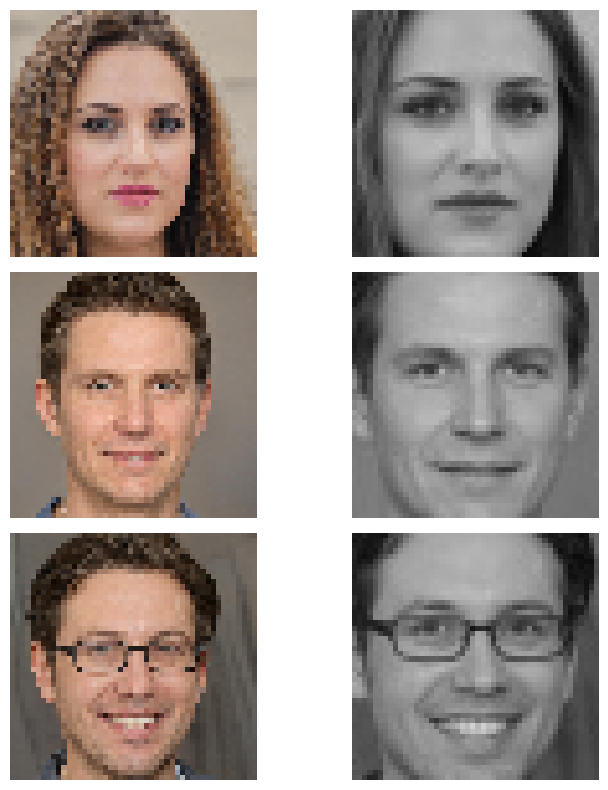

In [2]:
img_list = ['../archive-2/Images/no_glasses/face-1183.jpg', '../temp_glasses/Data-glasses/no_glasses/face-1183.jpg', '../archive-2/Images/no_glasses/face-171.jpg', '../temp_glasses/Data-glasses/no_glasses/face-171.jpg', '../archive-2/Images/glasses/face-61.jpg', '../temp_glasses/Data-glasses/glasses/face-61.jpg']

plt.figure(figsize=(8, 8))
j=1
for i in img_list:
    plt.subplot(3, 2, j)
    img1 = load_img(i, target_size=(48, 48))
    plt.imshow(img1)
    plt.axis('off')
    j = j+1
plt.tight_layout()
plt.show()

## Unzipping files in colab

In [1]:
# ! unzip '/content/temp/glasses.zip' -d '/content/images/glasses'
# ! unzip '/content/temp/no_glasses.zip' -d '/content/images/no_glasses'

## Printing loaded pictures

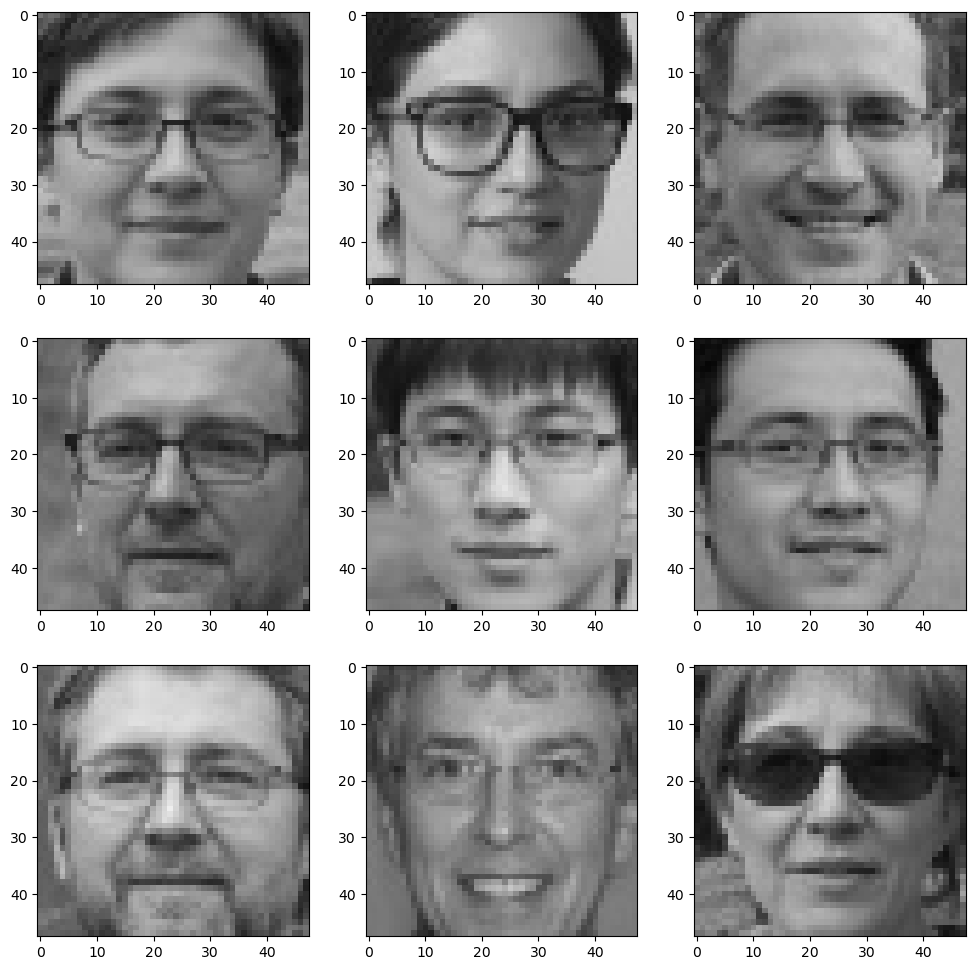

In [3]:
pic_size = 48
folder_path ="../temp_glasses/Data-glasses/"
glasses="glasses"

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+glasses+"/"+
                  os.listdir(folder_path+glasses+"/")[i], target_size=(pic_size, pic_size))
    plt.imshow(img)
plt.show()

## Train and Validation/Test-set

In [ ]:
# 25 % to validation/test and 75 % to train-set
# rescale pictures to get values from 0 to 1 instead of 255

# datagen_train_aug is a try with augmentation of the pictures, didn't do much for model so skipped it
# inspiration for augmentation and new model from https://www.kaggle.com/code/tamsquare/glasses-classification-cnn

In [4]:
pic_size = 48
folder_path ="../temp_glasses/Data-glasses/"
batch_size  = 128

datagen_train = ImageDataGenerator(validation_split=0.25, rescale=1.0/255.0)

datagen_train_aug  = ImageDataGenerator(rotation_range=20,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        rescale=1.0/255.0)

train_set = datagen_train.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "grayscale",
                                              subset="training",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

valid_set = datagen_train.flow_from_directory(folder_path,
                                              target_size = (pic_size,pic_size),
                                              color_mode = "grayscale",
                                              subset="validation",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)

augmented_images = datagen_train_aug.flow_from_directory(folder_path,
                                                         target_size=(pic_size,pic_size),
                                                         color_mode = "grayscale",
                                                         batch_size=1 
                                                        )

Found 3690 images belonging to 2 classes.
Found 1229 images belonging to 2 classes.
Found 4919 images belonging to 2 classes.


## Looking at augumented pictures

In [ ]:
# Plot of how the pictures looked like while augmented

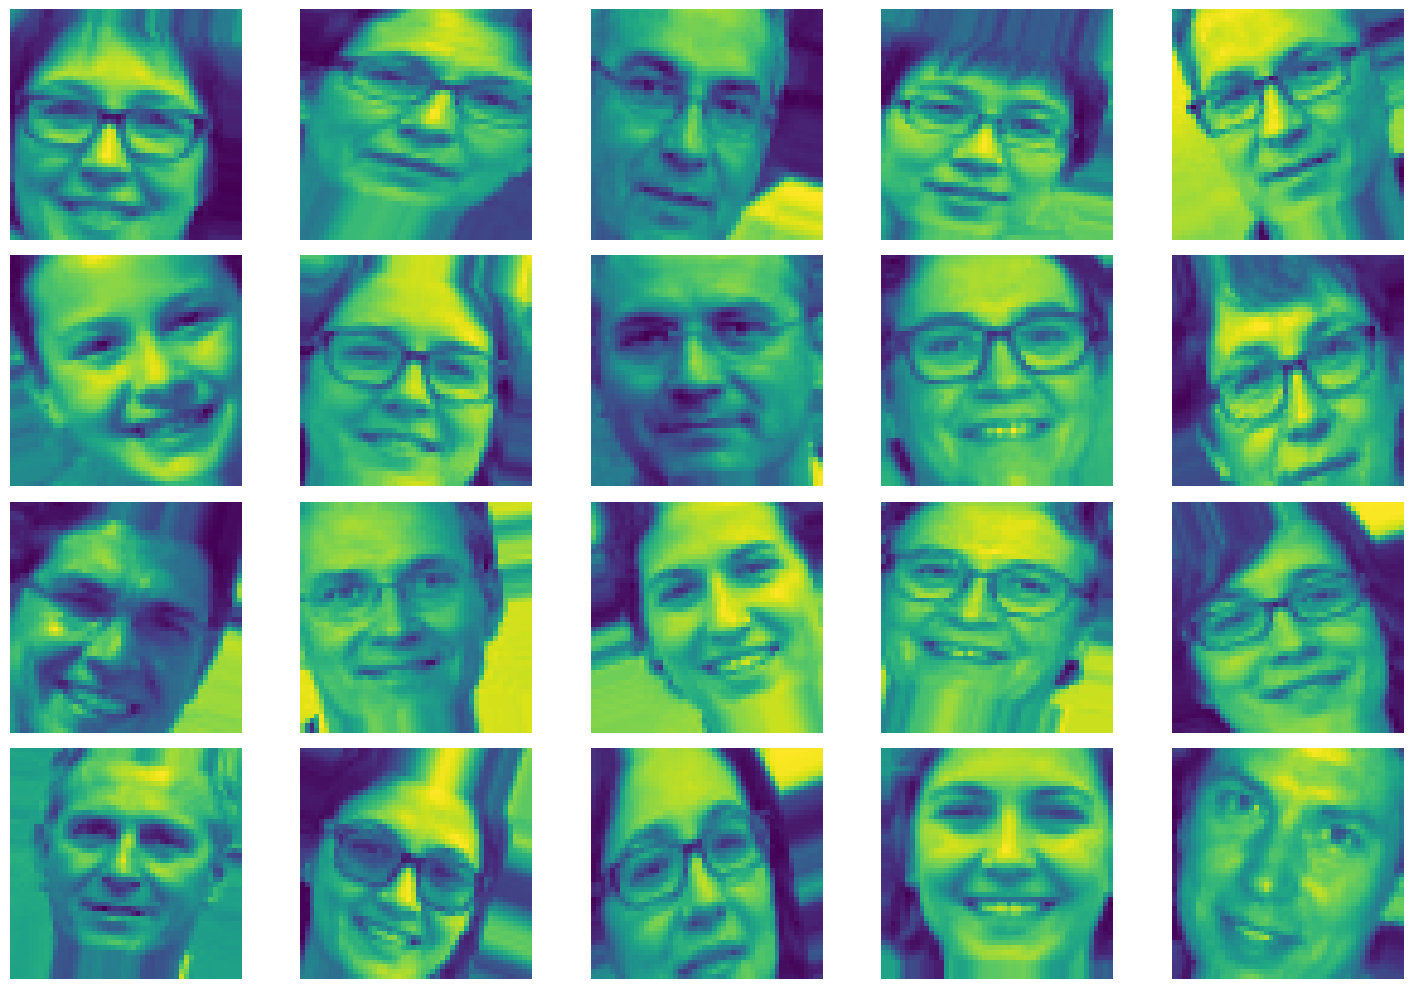

In [5]:
plt.figure(figsize=(15, 10))
for i in range(20):
    img = augmented_images.next()
    plt.subplot(4, 5, i + 1)
    image = img[0]
    image = np.reshape(image, (48,48,1))
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Create model

In [ ]:
# creating a simpler model, first model (same as for emotions) are below 

In [6]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

In [8]:
checkpoint = ModelCheckpoint('best_model_sofar_10.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

## Fitting model

In [ ]:
# new and old history, using a combination of both

In [9]:
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n//train_set.batch_size,
    epochs=48,
    validation_data = valid_set,
    validation_steps = valid_set.n//valid_set.batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/48
28/28 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.5876
Epoch 1: val_accuracy improved from -inf to 0.83507, saving model to best_model_sofar_10.h5
28/28 [==============================] - 4s 96ms/step - loss: 0.6492 - accuracy: 0.5876 - val_loss: 0.5400 - val_accuracy: 0.8351
Epoch 2/48
 2/28 [=>............................] - ETA: 1s - loss: 0.5196 - accuracy: 0.8477

C:\Users\frida\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8711
Epoch 2: val_accuracy improved from 0.83507 to 0.90538, saving model to best_model_sofar_10.h5
28/28 [==============================] - 3s 90ms/step - loss: 0.3410 - accuracy: 0.8711 - val_loss: 0.2342 - val_accuracy: 0.9054
Epoch 3/48
28/28 [==============================] - ETA: 0s - loss: 0.1944 - accuracy: 0.9222
Epoch 3: val_accuracy improved from 0.90538 to 0.95399, saving model to best_model_sofar_10.h5
28/28 [==============================] - 4s 155ms/step - loss: 0.1944 - accuracy: 0.9222 - val_loss: 0.1372 - val_accuracy: 0.9540
Epoch 4/48
28/28 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9531
Epoch 4: val_accuracy improved from 0.95399 to 0.96354, saving model to best_model_sofar_10.h5
28/28 [==============================] - 4s 147ms/step - loss: 0.1310 - accuracy: 0.9531 - val_loss: 0.1055 - val_accuracy: 0.9635
Epoch 5/48
28/28 [==============================] - 

## Accuracy

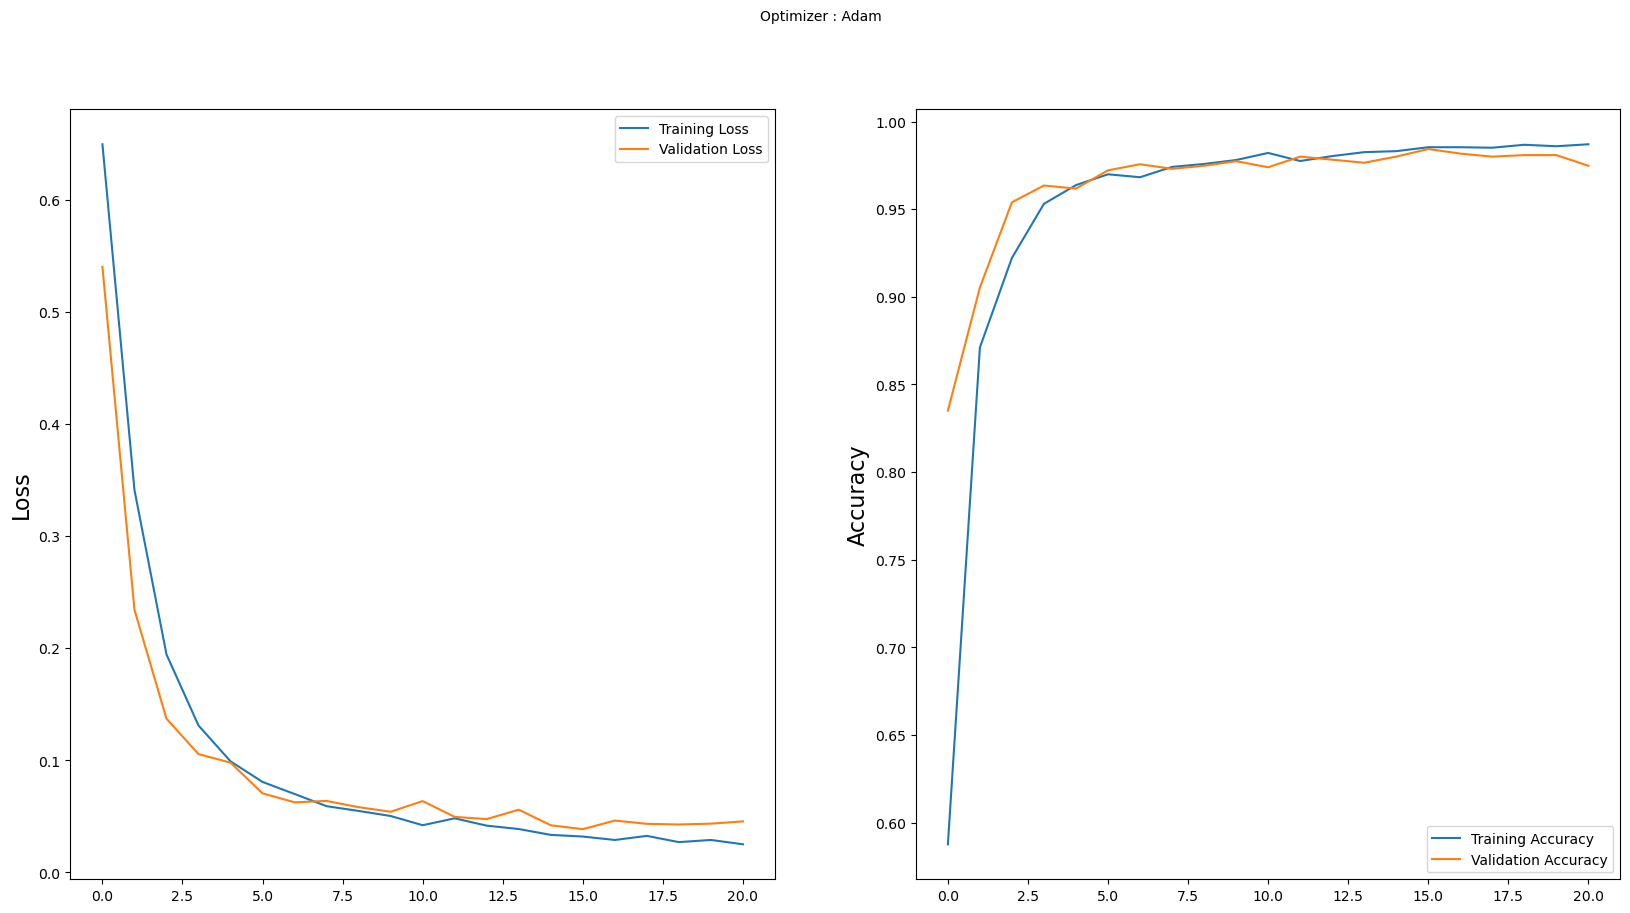

In [10]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## real time video to check model

In [11]:
from keras.models import load_model
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

In [12]:
# Instancing the face_classifier which is a xlm-software haar-cascade frontal face (Haar-like algorithms) that can detect faces in an image
# it returns a square that is 24 times 24 and shows the posititon oin x and y for the face
# so if I want to detect eyes I need to work with another classifier (?)
face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# loading my trained model
classifier =load_model('best_model_sofar_10.h5')


# the labels that we are detecting
emotion_labels = ['glasses','no glasses']

# Instanciate the videocamera
cap = cv2.VideoCapture(0)

# until you hit the q-button to close
# reading from camera and processing copy of image to grayscale
# identifying faces in different sizes with detect multiscale
# for the faces print a rectangle around and name the resized image inside to roi_gray
# if roi_grey exsist preprocess image to an array of typoe float
# redict the image and label the square around the face with the prediction
# if no faces can be identified write No Faces
# show/print the sqaure and the label
while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict(roi)[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step


## checking model with a few pictures

In [13]:
glasses_labels = ['glasses','no glasses']

img_grey = cv2.imread('../archive-2/Images/no_glasses/face-1183.jpg')
img_gray = cv2.cvtColor(img_grey,cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray,(48,48),interpolation=cv2.INTER_AREA)
img = img_gray.astype('float')/255.0
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
prediction = classifier.predict(img)[0]
label=glasses_labels[prediction.argmax()]
print(label)
print(prediction)

img_grey = cv2.imread('../archive-2/Images/glasses/face-61.jpg')
img_gray = cv2.cvtColor(img_grey,cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray,(48,48),interpolation=cv2.INTER_AREA)
img = img_gray.astype('float')/255.0
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
prediction = classifier.predict(img)[0]
label=glasses_labels[prediction.argmax()]
print(label)
print(prediction)

img_grey = cv2.imread('../archive-2/Images/no_glasses/face-200.jpg')
img_gray = cv2.cvtColor(img_grey,cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray,(48,48),interpolation=cv2.INTER_AREA)
img = img_gray.astype('float')/255.0
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
prediction = classifier.predict(img)[0]
label=glasses_labels[prediction.argmax()]
print(label)
print(prediction)

img_grey = cv2.imread('../archive-2/Images/no_glasses/face-174.jpg')
img_gray = cv2.cvtColor(img_grey,cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray,(48,48),interpolation=cv2.INTER_AREA)
img = img_gray.astype('float')/255.0
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
prediction = classifier.predict(img)[0]
label=glasses_labels[prediction.argmax()]
print(label)
print(prediction)

img_grey = cv2.imread('../archive-2/Images/no_glasses/face-171.jpg')
img_gray = cv2.cvtColor(img_grey,cv2.COLOR_BGR2GRAY)
img_gray = cv2.resize(img_gray,(48,48),interpolation=cv2.INTER_AREA)
img = img_gray.astype('float')/255.0
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
prediction = classifier.predict(img)[0]
label=glasses_labels[prediction.argmax()]
print(label)
print(prediction)

1/1 [==============================] - 0s 21ms/step
glasses
[0.8708153  0.12050371]
1/1 [==============================] - 0s 19ms/step
glasses
[9.9964249e-01 3.6831477e-04]
1/1 [==============================] - 0s 20ms/step
glasses
[0.9066034  0.08923883]
1/1 [==============================] - 0s 21ms/step
no glasses
[0.09793147 0.8904261 ]
1/1 [==============================] - 0s 17ms/step
no glasses
[0.33515173 0.6557085 ]


## CONCLUSION

When I started the only goal was to create a face-recognition model that could predict glasses or no glasses. This became my task since I found what I thought was a good dataset.

I downloaded the dataset, tried to do the big model from the emotion-code. Nothing worked, realised that I had to preprocess all images and found a solution. But the model was still not good, so I found another set-ut for the model and tried that one. which worked with Haarcascade.

The result is a model with loss: 0.0320 - accuracy: 0.9854 - val_loss: 0.0386 - val_accuracy: 0.9844
In this case the accuracy dosen't say so much about the result I get from real-time video though. Since it only shows how good the model is on data that is also preprocessed.

So I tried with some pictures berfore preprocessing and got 3 out of 5 as correct, the model before that 4 out of 5. Which I find is good enough.

If I want a better model I should hade a better and bigger dataset. I could also try with more or bigger layers in the model, or softmax instead of sigmoid as activation.